<a href="https://colab.research.google.com/github/SM-Learning/LLM-milvus-io-bootcamp/blob/master/NER_GLiNER_vs_BERT_vs_Spacy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
!pip install -q transformers datasets torch pandas numpy seaborn matplotlib scikit-learn

In [7]:
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModelForTokenClassification, TrainingArguments, Trainer
from datasets import Dataset
import torch
from sklearn.model_selection import train_test_split
import re
from seaborn import heatmap
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

In [8]:
from seaborn import heatmap
import seaborn as sns

from sklearn.utils.class_weight import compute_class_weight

In [11]:
def clean_text(text):
    if pd.isna(text):
        return ""
    return str(text).strip()

def extract_year(text):
    matches = re.findall(r'(?:founded|established|started)\s+in\s+(\d{4})', text.lower())
    return matches[0] if matches else ""

def prepare_training_data(df):
    training_examples = []

    for _, row in df.iterrows():
        desc = clean_text(row['description'])
        if not desc:
            continue

        year = str(row['year_established']) if pd.notna(row['year_established']) else ""
        products = [p.strip() for p in str(row['products']).split('|')] if pd.notna(row['products']) else []
        brands = [b.strip() for b in str(row['brands']).split('|')] if pd.notna(row['brands']) else []

        words = desc.split()
        labels = ['O'] * len(words)

        if year:
            for i, word in enumerate(words):
                if year in word:
                    labels[i] = 'B-YEAR'

        for product in products:
            if product:
                product_words = product.split()
                for i in range(len(words) - len(product_words) + 1):
                    if ' '.join(words[i:i+len(product_words)]).lower() == product.lower():
                        labels[i] = 'B-PRODUCT'
                        for j in range(1, len(product_words)):
                            labels[i+j] = 'I-PRODUCT'

        for brand in brands:
            if brand:
                brand_words = brand.split()
                for i in range(len(words) - len(brand_words) + 1):
                    if ' '.join(words[i:i+len(brand_words)]).lower() == brand.lower():
                        labels[i] = 'B-BRAND'
                        for j in range(1, len(brand_words)):
                            labels[i+j] = 'I-BRAND'

        training_examples.append({
            'words': words,
            'labels': labels
        })

    return training_examples

def tokenize_and_align_labels(examples, tokenizer):
    tokenized_inputs = tokenizer(
        examples["words"],
        truncation=True,
        is_split_into_words=True,
        max_length=512,
        padding=True
    )

    labels = []
    for i, label in enumerate(examples["labels"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                label_ids.append(label_ids_map[label[word_idx]])
            else:
                label_ids.append(-100)
            previous_word_idx = word_idx
        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

def train_model(train_dataset, eval_dataset):
    training_args = TrainingArguments(
        output_dir="./ner_model",
        num_train_epochs=3,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        logging_dir="./logs",
        logging_steps=10,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="eval_loss"
    )

    '''
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        compute_loss=weighted_loss  # Added to use custom loss function.
        )
    '''

    trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized,
    eval_dataset=eval_tokenized,
    )

    trainer.train()
    return trainer

def predict_entities(text, model, tokenizer):
    words = text.split()
    inputs = tokenizer(words, truncation=True, is_split_into_words=True, return_tensors="pt", padding=True)

    with torch.no_grad():
        outputs = model(**inputs)
        predictions = outputs.logits.argmax(dim=2)

    predicted_labels = []
    word_ids = inputs.word_ids()
    previous_word_idx = None

    for idx, pred in enumerate(predictions[0]):
        word_idx = word_ids[idx]
        if word_idx is None or word_idx == previous_word_idx:
            continue
        predicted_labels.append(id2label[pred.item()])
        previous_word_idx = word_idx

    entities = {
        'year': '',
        'products': set(),
        'brands': set()
    }

    current_entity = None
    current_text = []

    for word, label in zip(words, predicted_labels):
        if label.startswith('B-'):
            if current_entity:
                entity_text = ' '.join(current_text)
                if current_entity == 'YEAR':
                    entities['year'] = entity_text
                elif current_entity == 'PRODUCT':
                    entities['products'].add(entity_text)
                elif current_entity == 'BRAND':
                    entities['brands'].add(entity_text)
            current_entity = label[2:]
            current_text = [word]
        elif label.startswith('I-'):
            if current_entity:
                current_text.append(word)
        else:
            if current_entity:
                entity_text = ' '.join(current_text)
                if current_entity == 'YEAR':
                    entities['year'] = entity_text
                elif current_entity == 'PRODUCT':
                    entities['products'].add(entity_text)
                elif current_entity == 'BRAND':
                    entities['brands'].add(entity_text)
            current_entity = None
            current_text = []

    if current_entity:
        entity_text = ' '.join(current_text)
        if current_entity == 'YEAR':
            entities['year'] = entity_text
        elif current_entity == 'PRODUCT':
            entities['products'].add(entity_text)
        elif current_entity == 'BRAND':
            entities['brands'].add(entity_text)

    return {
        'year': entities['year'],
        'products': ','.join(entities['products']) if entities['products'] else '',
        'brands': ','.join(entities['brands']) if entities['brands'] else ''
    }

# Load and prepare data
df = pd.read_csv('/content/sample_data/company_data.csv')
df['description'] = df['description'].apply(clean_text)



In [12]:
df.head()

,description,year_established,products,brands
0,Axq company established in 1921 and headquarte...,1921.0,health insurance products,NaN
1,sd1 org is a global leader in software service...,NaN,cloud engineering | data architecture | data s...,NaN
2,"TechForward Inc., founded in 2015, with headqu...",2015.0,CRM solutions,NaN
3,"GlobalBio, established in 1998 in Boston, is a...",1998.0,medicines,NaN
4,"GreenEnergy Co, started in 2010, located in Lo...",2010.0,wind turbine | solar panel,NaN


In [14]:
# Prepare label mapping
unique_labels = ['O', 'B-YEAR', 'I-YEAR', 'B-PRODUCT', 'I-PRODUCT', 'B-BRAND', 'I-BRAND']
label_ids_map = {label: i for i, label in enumerate(unique_labels)}
id2label = {i: label for label, i in label_ids_map.items()}
label2id = {label: i for i, label in enumerate(unique_labels)}

# Prepare training data
training_examples = prepare_training_data(df)
train_data, eval_data = train_test_split(training_examples, test_size=0.2, random_state=42)

# Convert to datasets
train_dataset = Dataset.from_dict({
    'words': [example['words'] for example in train_data],
    'labels': [example['labels'] for example in train_data]
})
eval_dataset = Dataset.from_dict({
    'words': [example['words'] for example in eval_data],
    'labels': [example['labels'] for example in eval_data]
})

# Initialize tokenizer and model
model_name = "bert-base-cased"  # Changed to base BERT model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForTokenClassification.from_pretrained(
    model_name,
    num_labels=len(unique_labels),
    id2label=id2label,
    label2id=label2id
)

# Tokenize datasets
train_tokenized = train_dataset.map(
    lambda x: tokenize_and_align_labels(x, tokenizer),
    batched=True
)
eval_tokenized = eval_dataset.map(
    lambda x: tokenize_and_align_labels(x, tokenizer),
    batched=True
)


Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/20 [00:00<?, ? examples/s]

Map:   0%|          | 0/6 [00:00<?, ? examples/s]

In [15]:
all_unique_labels = ['O', 'B-YEAR', 'I-YEAR', 'B-PRODUCT', 'I-PRODUCT', 'B-BRAND', 'I-BRAND']

# Get unique labels from the training data
all_labels_in_data = set([label for example in training_examples for label in example['labels']])

# Filter unique labels and IDs to only include those present in the data
filtered_unique_labels = [label for label in all_unique_labels if label in all_labels_in_data]
filtered_unique_label_ids = np.array([label_ids_map[label] for label in filtered_unique_labels])

from collections import Counter
# Gather all labels from training data
all_labels = [label_ids_map[label] for example in training_examples for label in example['labels']]
label_counts = Counter(all_labels)



'''
# Ensure all unique labels are considered for weight calculation
all_unique_labels = ['O', 'B-YEAR', 'I-YEAR', 'B-PRODUCT', 'I-PRODUCT', 'B-BRAND', 'I-BRAND']
# Convert the list of unique label IDs to a NumPy array
unique_label_ids = np.array(list(range(len(all_unique_labels))))

# Calculate class weights using all unique labels and ensuring representation of all labels
# If a label is not in true_labels, its count will be 0, leading to a weight calculation for it.
from collections import Counter
# Gather all labels from training data
all_labels = [label_ids_map[label] for example in training_examples for label in example['labels']]
label_counts = Counter(all_labels)


all_labels_in_data = set([label for example in training_examples for label in example['labels']])
print("Unique labels in data:", all_labels_in_data)

# Print your defined unique labels
print("Defined unique labels:", set(all_unique_labels))
'''

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=filtered_unique_label_ids,
    y=all_labels
)

# Create a dictionary mapping label IDs to their weights
class_weights_dict = dict(zip(filtered_unique_label_ids, class_weights))

# Create a full class weights tensor with default weight for missing labels
full_class_weights = [class_weights_dict.get(i, 1.0) for i in range(len(all_unique_labels))]  # Default weight is 1.0

# Convert class weights to a tensor
class_weights_tensor = torch.tensor(full_class_weights, dtype=torch.float).to(model.device)
#class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(model.device)


class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.get("labels")
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss_fct = torch.nn.CrossEntropyLoss(weight=class_weights_tensor)
        loss = loss_fct(logits.view(-1, model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss


# Define a custom loss function with weighted loss
def weighted_loss(logits, labels):
    loss_fct = torch.nn.CrossEntropyLoss(weight=class_weights_tensor)
    loss = loss_fct(logits.view(-1, len(unique_labels)), labels.view(-1))
    return loss

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Epoch,Training Loss,Validation Loss
1,No log,2.128288
2,No log,2.418007
3,No log,2.535085



Model Evaluation Metrics:
Eval Loss: 2.1283

Classification Report:
              precision    recall  f1-score   support

           O       0.97      0.66      0.78       126
      B-YEAR       0.00      0.00      0.00         0
      I-YEAR       0.00      0.00      0.00         0
   B-PRODUCT       0.15      0.71      0.25         7
   I-PRODUCT       0.28      0.70      0.40        10
     B-BRAND       0.00      0.00      0.00         1
     I-BRAND       0.00      0.00      0.00         0

    accuracy                           0.66       144
   macro avg       0.20      0.30      0.20       144
weighted avg       0.87      0.66      0.73       144



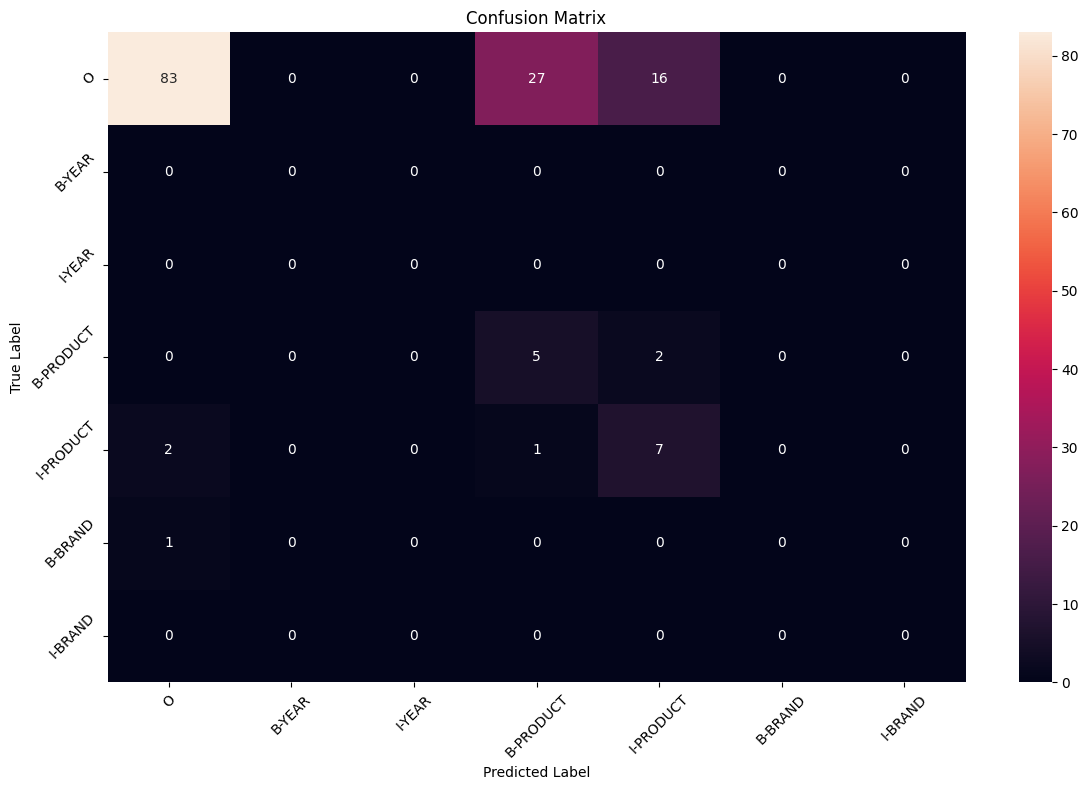

In [16]:
# Train model
trainer = train_model(train_tokenized, eval_tokenized)

# Evaluate model
eval_results = trainer.evaluate()

# Get predictions for evaluation set
eval_predictions = trainer.predict(eval_tokenized)
predictions = eval_predictions.predictions.argmax(-1)
labels = eval_predictions.label_ids

# Flatten predictions and labels, removing padding (-100)
true_labels = []
pred_labels = []

for prediction, label in zip(predictions, labels):
    for p, l in zip(prediction, label):
        if l != -100:  # Ignore padding tokens
            true_labels.append(id2label[l])
            pred_labels.append(id2label[p])

# Print results
print("\nModel Evaluation Metrics:")
print(f"Eval Loss: {eval_results['eval_loss']:.4f}")

# Calculate and print classification report
print("\nClassification Report:")
print(classification_report(true_labels, pred_labels, labels=unique_labels))


# Plot confusion matrix
plt.figure(figsize=(12, 8))
cm = confusion_matrix(true_labels, pred_labels, labels=unique_labels)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=unique_labels, yticklabels=unique_labels)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

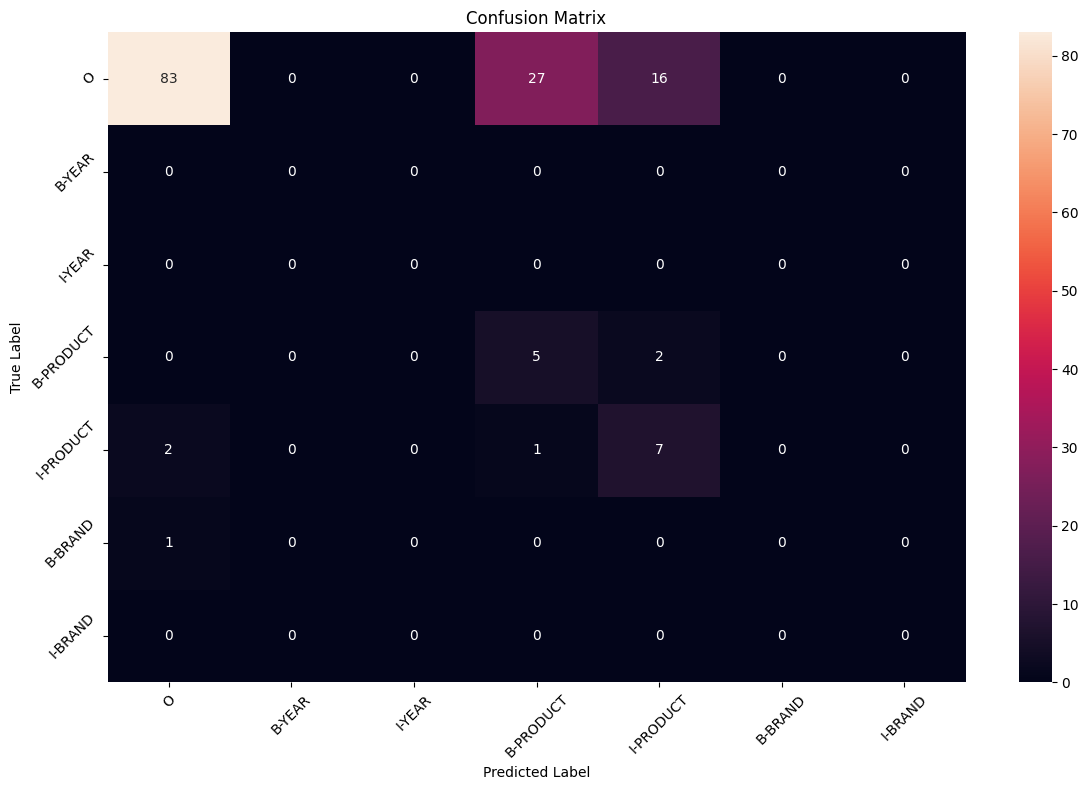

In [17]:
# Plot confusion matrix
#sns.heatmap(cm, annot=True, fmt='d', xticklabels=unique_labels, yticklabels=unique_labels)
plt.figure(figsize=(12, 8))
cm = confusion_matrix(true_labels, pred_labels, labels=unique_labels)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=unique_labels, yticklabels=unique_labels)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

In [18]:
# Generate sample predictions
sample_descriptions = [
    "TechCorp, founded in 2019, provides cloud computing and AI solutions under the CloudTech brand.",
    "BioMed Solutions established in 2005 manufactures medical devices and pharmaceuticals. Brands include BioMed X and Med Y",
    "RetailOne started in 2015 sells electronics and clothing under the SmartShop and FashionPlus brands."
]

results = []
for desc in sample_descriptions:
    entities = predict_entities(desc, model, tokenizer)
    results.append({
        'description': desc,
        'year': entities['year'],
        'products': entities['products'],
        'brands': entities['brands']
    })

print("\nSample Predictions:")
results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))


Sample Predictions:
                                                                                                             description year                                         products brands
                         TechCorp, founded in 2019, provides cloud computing and AI solutions under the CloudTech brand.      cloud computing,AI solutions,CloudTech,TechCorp,       
BioMed Solutions established in 2005 manufactures medical devices and pharmaceuticals. Brands include BioMed X and Med Y       X,Y,medical devices,Med,BioMed,pharmaceuticals.       
                    RetailOne started in 2015 sells electronics and clothing under the SmartShop and FashionPlus brands.                                           electronics       


In [19]:
results_df

,description,year,products,brands
0,"TechCorp, founded in 2019, provides cloud comp...",,"cloud computing,AI solutions,CloudTech,TechCorp,",
1,BioMed Solutions established in 2005 manufactu...,,"X,Y,medical devices,Med,BioMed,pharmaceuticals.",
2,RetailOne started in 2015 sells electronics an...,,electronics,



---

**# Spacy Model**
---



In [20]:
!pip install -q spacy
!python -m spacy download en_core_web_lg

import spacy

# Load the large English language model
nlp = spacy.load("en_core_web_lg")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 1.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [21]:
spacy_results = []
for desc in sample_descriptions:
    doc = nlp(desc)
    entities = {
        'year': '',
        'products': set(),
        'brands': set()
    }
    for ent in doc.ents:
        if ent.label_ == "DATE":
            entities['year'] = ent.text
        elif ent.label_ in ["ORG", "PRODUCT"]:  # Assuming organizations and products map to products
            entities['products'].add(ent.text)
        elif ent.label_ == "ORG": # Assuming organizations map to brands
            entities['brands'].add(ent.text)

    spacy_results.append({
        'description': desc,
        'year': entities['year'],
        'products': ','.join(entities['products']) if entities['products'] else '',
        'brands': ','.join(entities['brands']) if entities['brands'] else ''
    })

print("\nSpacy Predictions:")
spacy_results_df = pd.DataFrame(spacy_results)
print(spacy_results_df.to_string(index=False))
spacy_results_df

#Comparison
comparison_df = pd.DataFrame({
    'Description': results_df['description'],
    'BERT Year': results_df['year'],
    'Spacy Year': spacy_results_df['year'],
    'BERT Products': results_df['products'],
    'Spacy Products': spacy_results_df['products'],
    'BERT Brands': results_df['brands'],
    'Spacy Brands': spacy_results_df['brands']
})

print("\nComparison of BERT and spaCy Results:")
print(comparison_df.to_string(index=False))
comparison_df


Spacy Predictions:
                                                                                                             description year                  products brands
                         TechCorp, founded in 2019, provides cloud computing and AI solutions under the CloudTech brand. 2019     TechCorp,CloudTech,AI       
BioMed Solutions established in 2005 manufactures medical devices and pharmaceuticals. Brands include BioMed X and Med Y 2005 BioMed X,BioMed Solutions       
                    RetailOne started in 2015 sells electronics and clothing under the SmartShop and FashionPlus brands. 2015                 RetailOne       

Comparison of BERT and spaCy Results:
                                                                                                             Description BERT Year Spacy Year                                    BERT Products            Spacy Products BERT Brands Spacy Brands
                         TechCorp, founded in 2019, provides cl

,Description,BERT Year,Spacy Year,BERT Products,Spacy Products,BERT Brands,Spacy Brands
0,"TechCorp, founded in 2019, provides cloud comp...",,2019,"cloud computing,AI solutions,CloudTech,TechCorp,","TechCorp,CloudTech,AI",,
1,BioMed Solutions established in 2005 manufactu...,,2005,"X,Y,medical devices,Med,BioMed,pharmaceuticals.","BioMed X,BioMed Solutions",,
2,RetailOne started in 2015 sells electronics an...,,2015,electronics,RetailOne,,



---

**# GliNER Model**

---



In [82]:
!pip install -q gliner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 25.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 4.5 MB/s eta 0:00:00


In [22]:
from gliner import GLiNER
model = GLiNER.from_pretrained("urchade/gliner_large-v2.1")

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

gliner_config.json:   0%|          | 0.00/477 [00:00<?, ?B/s]

.gitattributes:   0%|          | 0.00/1.52k [00:00<?, ?B/s]

README.md:   0%|          | 0.00/4.77k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.78G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/580 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

In [23]:
# prompt: Download and use the GLiNER large v2.1 multi model. use zero shot Gliner model. define labels for GliNER model such as "year established", product and brand. Add a few alias labels.   year established should be four digit year only.
# Test the GliNER , spacy large model and bert models responses against the sample_descriptions.

gliner_results = []
labels = ["year established", "product", "brand"]

aliases = {
    "year established": ["founded in", "established in", "started in"],
    "product": ["provides", "manufactures", "sells","products", "solution", "service", "item", "offering"],
    "brand": ["under the","brand", "brands", "trademark", "label"]
}

for desc in sample_descriptions:
    entities = model.predict_entities(desc, labels)
    year = ""
    products = set()
    brands = set()

    for entity in entities:
        if entity["label"] == "year established":
            if entity["text"].isdigit() and len(entity["text"])==4:
              year = entity["text"]
        elif entity["label"] == "product":
            products.add(entity["text"])
        elif entity["label"] == "brand":
            brands.add(entity["text"])

    gliner_results.append({
        'description': desc,
        'year': year,
        'products': ','.join(products),
        'brands': ','.join(brands)
    })

print("\nGLiNER Predictions:")
gliner_results_df = pd.DataFrame(gliner_results)
print(gliner_results_df.to_string(index=False))
gliner_results_df

#Comparison with all 3 models
comparison_df = pd.DataFrame({
    'Description': results_df['description'],
    'BERT Year': results_df['year'],
    'Spacy Year': spacy_results_df['year'],
    'GLiNER Year': gliner_results_df['year'],
    'BERT Products': results_df['products'],
    'Spacy Products': spacy_results_df['products'],
    'GLiNER Products': gliner_results_df['products'],
    'BERT Brands': results_df['brands'],
    'Spacy Brands': spacy_results_df['brands'],
    'GLiNER Brands': gliner_results_df['brands']
})

print("\nComparison of BERT, spaCy and GLiNER Results:")
print(comparison_df.to_string(index=False))
comparison_df

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



GLiNER Predictions:
                                                                                                             description year                        products                          brands
                         TechCorp, founded in 2019, provides cloud computing and AI solutions under the CloudTech brand. 2019                    AI solutions                       CloudTech
BioMed Solutions established in 2005 manufactures medical devices and pharmaceuticals. Brands include BioMed X and Med Y 2005 medical devices,pharmaceuticals Med Y,BioMed X,BioMed Solutions
                    RetailOne started in 2015 sells electronics and clothing under the SmartShop and FashionPlus brands. 2015            clothing,electronics           FashionPlus,SmartShop

Comparison of BERT, spaCy and GLiNER Results:
                                                                                                             Description BERT Year Spacy Year GLiNER Year                   

,Description,BERT Year,Spacy Year,GLiNER Year,BERT Products,Spacy Products,GLiNER Products,BERT Brands,Spacy Brands,GLiNER Brands
0,"TechCorp, founded in 2019, provides cloud comp...",,2019,2019,"cloud computing,AI solutions,CloudTech,TechCorp,","TechCorp,CloudTech,AI",AI solutions,,,CloudTech
1,BioMed Solutions established in 2005 manufactu...,,2005,2005,"X,Y,medical devices,Med,BioMed,pharmaceuticals.","BioMed X,BioMed Solutions","medical devices,pharmaceuticals",,,"Med Y,BioMed X,BioMed Solutions"
2,RetailOne started in 2015 sells electronics an...,,2015,2015,electronics,RetailOne,"clothing,electronics",,,"FashionPlus,SmartShop"


In [24]:
#Comparison with GliNER
comparison_df = pd.DataFrame({
    'Description': results_df['description'],
    'BERT Year': results_df['year'],
    'Spacy Year': spacy_results_df['year'],
    'GliNER Year': gliner_results_df['year'],
    'BERT Products': results_df['products'],
    'Spacy Products': spacy_results_df['products'],
    'GliNER Products': gliner_results_df['products'],
    'BERT Brands': results_df['brands'],
    'Spacy Brands': spacy_results_df['brands'],
    'GliNER Brands': gliner_results_df['brands']
})

print("\nComparison of BERT, spaCy, and GliNER Results:")
print(comparison_df.to_string(index=False))
comparison_df



Comparison of BERT, spaCy, and GliNER Results:
                                                                                                             Description BERT Year Spacy Year GliNER Year                                    BERT Products            Spacy Products                 GliNER Products BERT Brands Spacy Brands                   GliNER Brands
                         TechCorp, founded in 2019, provides cloud computing and AI solutions under the CloudTech brand.                 2019        2019 cloud computing,AI solutions,CloudTech,TechCorp,     TechCorp,CloudTech,AI                    AI solutions                                                CloudTech
BioMed Solutions established in 2005 manufactures medical devices and pharmaceuticals. Brands include BioMed X and Med Y                 2005        2005  X,Y,medical devices,Med,BioMed,pharmaceuticals. BioMed X,BioMed Solutions medical devices,pharmaceuticals                          Med Y,BioMed X,BioMed Solution

,Description,BERT Year,Spacy Year,GliNER Year,BERT Products,Spacy Products,GliNER Products,BERT Brands,Spacy Brands,GliNER Brands
0,"TechCorp, founded in 2019, provides cloud comp...",,2019,2019,"cloud computing,AI solutions,CloudTech,TechCorp,","TechCorp,CloudTech,AI",AI solutions,,,CloudTech
1,BioMed Solutions established in 2005 manufactu...,,2005,2005,"X,Y,medical devices,Med,BioMed,pharmaceuticals.","BioMed X,BioMed Solutions","medical devices,pharmaceuticals",,,"Med Y,BioMed X,BioMed Solutions"
2,RetailOne started in 2015 sells electronics an...,,2015,2015,electronics,RetailOne,"clothing,electronics",,,"FashionPlus,SmartShop"


# Custom Train GliNER model

In [26]:
!pip install -q datasets
!pip install -q --upgrade gliner

In [32]:
!pip show gliner

Name: gliner
Version: 0.2.16
Summary: Generalist model for NER (Extract any entity types from texts)
Home-page: https://github.com/urchade/GLiNER
Author: Urchade Zaratiana, Nadi Tomeh, Pierre Holat, Thierry Charnois
Author-email: 
License: Apache-2.0
Location: /usr/local/lib/python3.11/dist-packages
Requires: huggingface_hub, onnxruntime, sentencepiece, torch, tqdm, transformers
Required-by: 


In [33]:
from gliner import GLiNER
from gliner.training import Trainer # Import Trainer from gliner.training
from datasets import Dataset

In [34]:
def prepare_gliner_training_data(df):
    gliner_data = []
    for _, row in df.iterrows():
        desc = clean_text(row['description'])
        if not desc:
            continue

        entities = []

        year = str(row['year_established']) if pd.notna(row['year_established']) else ""
        if year:
            start_index = desc.find(year)
            if start_index != -1:
                entities.append({"label": "year established", "text": year, "start": start_index, "end": start_index + len(year)})

        products = [p.strip() for p in str(row['products']).split('|')] if pd.notna(row['products']) else []
        for product in products:
            if product:
                start_index = desc.lower().find(product.lower())
                if start_index != -1:
                    entities.append({"label": "product", "text": product, "start": start_index, "end": start_index + len(product)})

        brands = [b.strip() for b in str(row['brands']).split('|')] if pd.notna(row['brands']) else []
        for brand in brands:
            if brand:
                start_index = desc.lower().find(brand.lower())
                if start_index != -1:
                    entities.append({"label": "brand", "text": brand, "start": start_index, "end": start_index + len(brand)})

        gliner_data.append({"text": desc, "entities": entities})

    return gliner_data


In [1]:
# Prepare data for GLiNER
gliner_train_data = prepare_gliner_training_data(df)
gliner_dataset = Dataset.from_list(gliner_train_data)

# Split into train and validation sets
train_dataset, validation_dataset = gliner_dataset.train_test_split(test_size=0.2).values()

# Initialize GLiNER model and trainer
model = GLiNER.from_pretrained("urchade/gliner_large-v2.1")


from transformers import TrainingArguments # Import TrainingArguments

training_args = TrainingArguments(
    output_dir="./gliner_model",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    evaluation_strategy="epoch",
)

trainer = Trainer(model=model, train_dataset=gliner_dataset['train'], validation_dataset=gliner_dataset['test'], args=training_args)

#trainer = Trainer(model, train_dataset, validation_dataset, args=training_args)
#trainer = Trainer(model, train_dataset, validation_dataset)   # , batch_size=8, epochs=3


#trainer.batch_size = 8
#trainer.epochs = 3

# Train the model
trainer.train()

# Evaluate the model
results = trainer.evaluate()
print(results)  # Print validation results


NameError: name 'prepare_gliner_training_data' is not defined